In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

from convexmtl_torch.model.ConvexTorchCombinator import ConvexTorchCombinator
from convexmtl_torch.model.GraphLaplacianTorchCombinator import GraphLaplacianTorchCombinator
from convexmtl_torch.model.utils import NeuralNetwork

from convexmtl_torch.data.MTLSyntheticDataset import MTLCommonRegression

import torch
from torch.nn import MSELoss
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from icecream import ic

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

from copy import copy


In [2]:
seed = 1

np.random.seed(seed)
random.seed(seed)

In [3]:
max_epochs=2
log_every_n_steps=10
problem = 'common'

In [4]:
mtlds = MTLCommonRegression(n_samples_per_task=100)

X, y = mtlds.X, mtlds.y

if y.ndim < 2:
    y = y[:, None]

ic| tasks: [0, 1, 2, 3, 4]
ic| colors: {0: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
             1: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
             2: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
             3: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
             4: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)}
ic| X_data.shape: (500, 1)


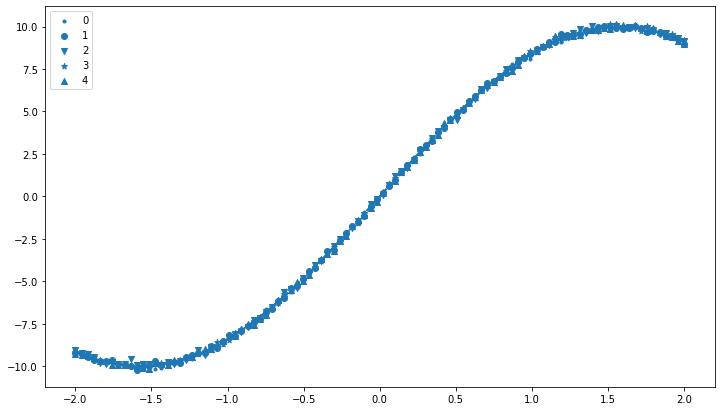

In [5]:
mtlds.plot_data_functions(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_test_numpy = copy(X_test)

In [7]:
X_train, t_train = X_train[:,:-1], X_train[:,-1].astype(int)
X_test, t_test = X_test[:,:-1], X_test[:,-1].astype(int)
X_train, t_train, y_train = map(torch.tensor, (X_train, t_train, y_train))
X_train, t_train, y_train = map(lambda obj: obj.float(), [X_train, t_train, y_train])
X_test, t_test, y_test = map(torch.tensor, (X_test, t_test, y_test))
X_test, t_test, y_test = map(lambda obj: obj.float(), [X_test, t_test, y_test])


In [8]:
tasks = np.unique(t_train)
n_tasks = len(tasks)

In [9]:
# train_ds = TensorDataset(X_train, t_train, y_train)
train_ds = TensorDataset(X_train, t_train, y_train)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)



## ConvexMTL Torch

In [10]:
max_epochs = 5

In [11]:
model = ConvexTorchCombinator(n_features=1, n_output=1, n_channel=1, tasks=tasks, specific_lambda=False)
# model = NeuralNetwork(n_features=1)

In [12]:
trainer = Trainer(max_epochs=max_epochs, log_every_n_steps=log_every_n_steps, default_root_dir='convex_{}_logs'.format(problem))

trainer.fit(model, train_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type          | Params
-------------------------------------------------
0 | common_module_ | NeuralNetwork | 8.5 K 
-------------------------------------------------
8.5 K     Trainable params
0         Non-trainable params
8.5 K     Total params
0.034     Total estimated model params size (MB)
/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 54.50it/s, loss=18.7, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 50.44it/s, loss=18.7, v_num=1]


In [13]:
model.tasks

array([0., 1., 2., 3., 4.], dtype=float32)

In [14]:
# pred = model(X_test, t_test)
pred = model(X_test, t_test)

In [15]:
pred_numpy = pred.detach().numpy()
pred_numpy.shape

(165, 1)

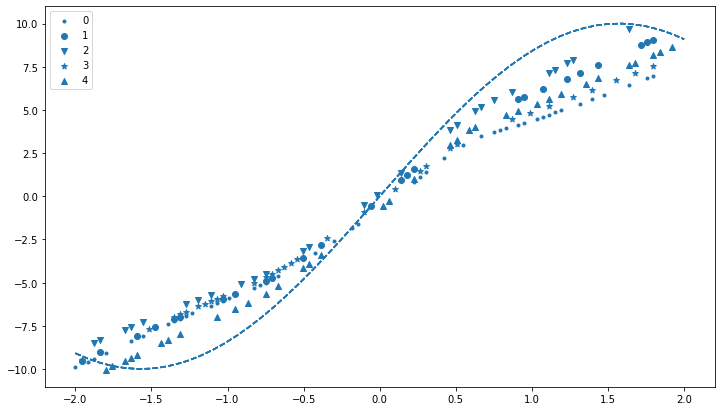

In [16]:
mtlds.plot_data_functions(X_test_numpy, pred_numpy)

In [17]:
model.get_lamb()

ic| self.lamb: Parameter containing:
               tensor([0.3784], requires_grad=True)


array([0.59348243], dtype=float32)

## GraphLaplacian Torch

In [18]:
max_epochs=101

In [19]:
model = GraphLaplacianTorchCombinator(n_features=1, n_output=1, n_channel=1, tasks=tasks, nu=0.1, mu=0.05, adj_lr=1e-2, log_matrix_freq=50)
# model = NeuralNetwork(n_features=1)

In [20]:
trainer = Trainer(max_epochs=max_epochs, log_every_n_steps=log_every_n_steps, default_root_dir='gl_{}_logs'.format(problem))

trainer.fit(model, train_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type                   | Params
----------------------------------------------------------
0 | common_module_ | NeuralNetworkFeatLearn | 8.4 K 
----------------------------------------------------------
8.4 K     Trainable params
0         Non-trainable params
8.4 K     Total params
0.034     Total estimated model params size (MB)
/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 11/11 [00:00<00:00, 12.49it/s, loss=57.5, v_num=1]

ic| self.get_adjMatrix(): array([[1.00000000e+00, 1.14242837e-09, 1.14242404e-09, 1.14241516e-09,
                                  1.14243048e-09],
                                 [1.14242837e-09, 1.00000000e+00, 1.14242837e-09, 1.14241305e-09,
                                  1.14241960e-09],
                                 [1.14242404e-09, 1.14242837e-09, 1.00000000e+00, 1.14242404e-09,
                                  1.14242404e-09],
                                 [1.14241516e-09, 1.14241305e-09, 1.14242404e-09, 1.00000000e+00,
                                  1.14241305e-09],
                                 [1.14243048e-09, 1.14241960e-09, 1.14242404e-09, 1.14241305e-09,
                                  1.00000000e+00]])
ic| self.entropy: {0.0: {0.0: tensor([[-0.]], grad_fn=<MulBackward0>),
                         1.0: tensor([[2.3253e-08]], grad_fn=<MulBackward0>),
                         2.0: tensor([[2.3253e-08]], grad_fn=<MulBackward0>),
                         3.

Epoch 50: 100%|██████████| 11/11 [00:00<00:00, 19.62it/s, loss=0.105, v_num=1]

ic| self.get_adjMatrix(): array([[9.99979079e-01, 5.30510215e-06, 5.17079616e-06, 5.02853118e-06,
                                  5.42149110e-06],
                                 [5.30512307e-06, 9.99979198e-01, 5.30008629e-06, 4.96134726e-06,
                                  5.14594376e-06],
                                 [5.17079616e-06, 5.30008583e-06, 9.99979079e-01, 5.25646328e-06,
                                  5.18707520e-06],
                                 [5.02853482e-06, 4.96135044e-06, 5.25646738e-06, 9.99979854e-01,
                                  4.88759133e-06],
                                 [5.42149246e-06, 5.14594467e-06, 5.18707657e-06, 4.88758860e-06,
                                  9.99979317e-01]])
ic| self.entropy: {0.0: {0.0: tensor([[2.0087e-05]], grad_fn=<MulBackward0>),
                         1.0: tensor([[6.2261e-05]], grad_fn=<MulBackward0>),
                         2.0: tensor([[6.0831e-05]], grad_fn=<MulBackward0>),
                    

Epoch 100: 100%|██████████| 11/11 [00:00<00:00, 16.89it/s, loss=0.00854, v_num=1]

ic| self.get_adjMatrix(): array([[0.29703927, 0.19026019, 0.17327188, 0.14220133, 0.19722731],
                                 [0.19069777, 0.32619238, 0.17612492, 0.14713641, 0.15984853],
                                 [0.17354555, 0.17598346, 0.312767  , 0.18098511, 0.15671891],
                                 [0.14371163, 0.14826928, 0.18262863, 0.40412503, 0.12126537],
                                 [0.19856036, 0.1604642 , 0.1574946 , 0.12077823, 0.36270273]])
ic| self.entropy: {0.0: {0.0: tensor([[0.3606]], grad_fn=<MulBackward0>),
                         1.0: tensor([[0.3157]], grad_fn=<MulBackward0>),
                         2.0: tensor([[0.3037]], grad_fn=<MulBackward0>),
                         3.0: tensor([[0.2773]], grad_fn=<MulBackward0>),
                         4.0: tensor([[0.3202]], grad_fn=<MulBackward0>)},
                   1.0: {0.0: tensor([[0.3160]], grad_fn=<MulBackward0>),
                         1.0: tensor([[0.3654]], grad_fn=<MulBackward0>),
     

Epoch 100: 100%|██████████| 11/11 [00:01<00:00,  6.21it/s, loss=0.00854, v_num=1]

`Trainer.fit` stopped: `max_epochs=101` reached.


Epoch 100: 100%|██████████| 11/11 [00:01<00:00,  5.99it/s, loss=0.00854, v_num=1]


In [21]:
model.get_adjMatrix()

array([[0.29703927, 0.19026019, 0.17327188, 0.14220133, 0.19722731],
       [0.19069777, 0.32619238, 0.17612492, 0.14713641, 0.15984853],
       [0.17354555, 0.17598346, 0.312767  , 0.18098511, 0.15671891],
       [0.14371163, 0.14826928, 0.18262863, 0.40412503, 0.12126537],
       [0.19856036, 0.1604642 , 0.1574946 , 0.12077823, 0.36270273]])

In [22]:
# pred = model(X_test, t_test)
pred = model(X_test, t_test)

In [23]:
pred_numpy = pred.detach().numpy()
pred_numpy.shape

(165, 1)

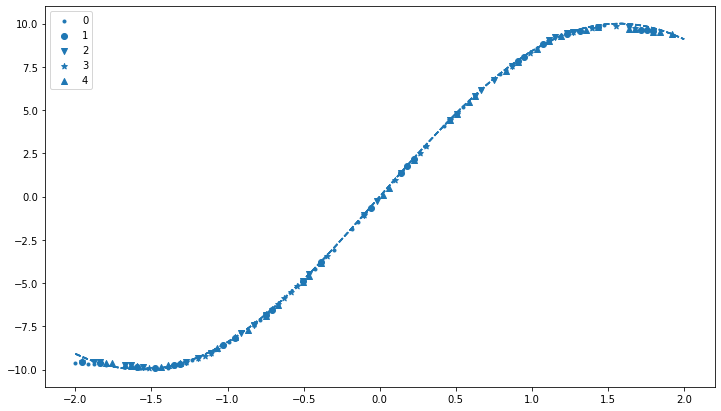

In [24]:
mtlds.plot_data_functions(X_test_numpy, pred_numpy)

In [25]:
adjMatrix = model.get_adjMatrix()

In [26]:
adjMatrix

array([[0.29703927, 0.19026019, 0.17327188, 0.14220133, 0.19722731],
       [0.19069777, 0.32619238, 0.17612492, 0.14713641, 0.15984853],
       [0.17354555, 0.17598346, 0.312767  , 0.18098511, 0.15671891],
       [0.14371163, 0.14826928, 0.18262863, 0.40412503, 0.12126537],
       [0.19856036, 0.1604642 , 0.1574946 , 0.12077823, 0.36270273]])

<AxesSubplot:>

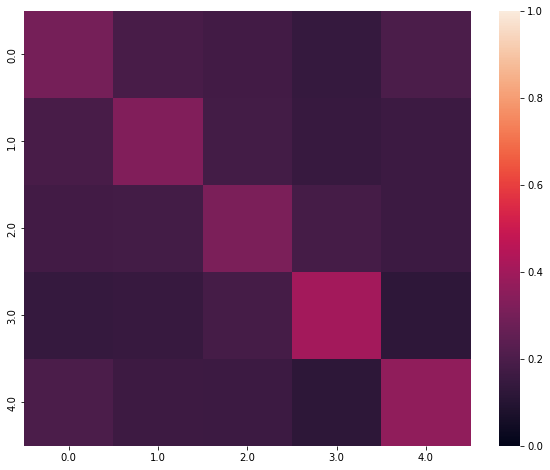

In [27]:
import seaborn as sns

plt.figure(figsize=(10, 8))
ax = plt.gca()
sns.heatmap(adjMatrix, xticklabels=tasks, yticklabels=tasks, vmin=0, vmax=1, ax=ax)

## tensorboard

In [28]:
%reload_ext tensorboard
%tensorboard --logdir=gl_common_logs/